# Tutorial 1 - Shortest path analysis for single OD pair using Networkx

```{attention}
Finnish university students are encouraged to use the CSC Notebooks platform.<br/>
<a href="https://notebooks.csc.fi"><img alt="CSC badge" src="https://img.shields.io/badge/launch-CSC%20notebook-blue.svg" style="vertical-align:text-bottom"></a>

Others can follow the lesson interactively using Binder. Check the rocket icon on the top of this page.
```

**Lesson objectives**

This tutorial focuses on **spatial networks** and learn how to construct a routable **directed** graph for Networkx and find shortest paths along the given street network based on travel times or distance by car. In addition, we will learn how to calculate travel times from a single source into all nodes in the graph. 

## Introduction to Networkx

In this tutorial we will focus on a network analysis methods that relate to way-finding. Finding a shortest path from A to B using a specific street network is a very common spatial analytics problem that has many practical applications.

Python provides easy to use tools for conducting spatial network analysis.
One of the easiest ways to start is to use a library
called [Networkx](https://networkx.github.io/documentation/stable/)
which is a Python module that provides a lot tools that can be used to
analyze networks on various different ways. It also contains algorithms
such as [Dijkstra’s
algorithm](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.weighted.single_source_dijkstra.html#networkx.algorithms.shortest_paths.weighted.single_source_dijkstra)
or [A\*](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.astar.astar_path.html#networkx.algorithms.shortest_paths.astar.astar_path)
algoritm that are commonly used to find shortest paths along
transportation network.

## Data and Methodology
In this part, we will learn how to do spatial network analysis in practice.

### Typical workflow for routing

If you want to conduct network analysis (in any programming language) there are a few basic steps that typically needs to be done before you can start routing. These steps are:

 1. **Retrieve data** (such as street network from OSM or Digiroad + possibly transit data if routing with PT).
 2. **Modify the network** by adding/calculating edge weights (such as travel times based on speed limit and length of the road segment).
 3. **Build a routable graph** for the routing tool that you are using (e.g. for NetworkX, igraph or OpenTripPlanner).
 4. **Conduct network analysis** (such as shortest path analysis) with the routing tool of your choice. 

### 1. Retrieve data

As a first step, we need to obtain data for routing. [Pyrosm](https://pyrosm.readthedocs.io/en/latest/) library makes it really easy to retrieve routable networks from OpenStreetMap (OSM) with different transport modes (walking, cycling and driving). 

- Let's first extract OSM data for Helsinki that are walkable. In `pyrosm`, we can use a function called `osm.get_network()` which retrieves data from OpenStreetMap. It is possible to specify what kind of roads should be retrieved from OSM with `network_type` -parameter (supports `walking`, `cycling`, `driving`). 


C:\Users\deys1\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyrosm\networks.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  edges, nodes = prepare_geodataframe(


<Axes: >

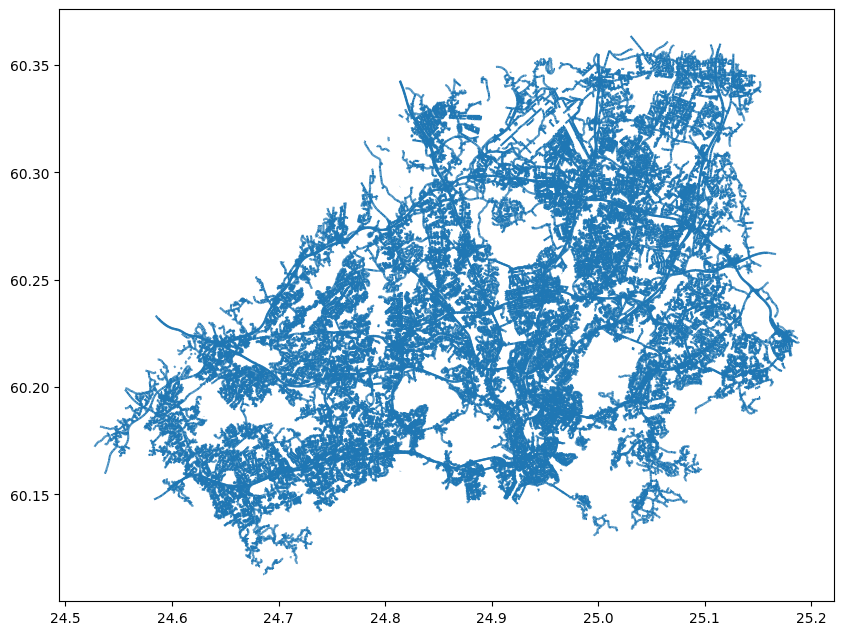

In [166]:
from pyrosm import OSM, get_data
import geopandas as gpd
import pandas as pd
import networkx as nx

# We will use test data for Helsinki that comes with pyrosm
##osm = OSM(get_data("helsinki_pbf"))
osm = OSM("data/Helsinki_larger_region.osm.pbf")

# Parse roads that can be driven by car
roads = osm.get_network(network_type="driving")
roads.plot(figsize=(10,10))

In [167]:
roads.head(2)

,access,area,bicycle,bridge,busway,cycleway,est_width,foot,footway,highway,...,tunnel,turn,width,id,timestamp,version,tags,osm_type,geometry,length
0,None,None,None,None,None,None,None,None,None,motorway,...,None,None,None,2293993,1522365641,21,"{""visible"":false,""light:method"":""high_pressure...",way,"MULTILINESTRING ((25.12612 60.25746, 25.12709 ...",612.0
1,None,None,no,None,None,None,None,no,None,trunk,...,None,None,None,2294195,1656446984,26,"{""visible"":false,""TEN-T"":""core"",""functional_cl...",way,"MULTILINESTRING ((25.15740 60.23955, 25.15673 ...",144.0


Okay, now we have drivable roads as a GeoDataFrame for the city center of Helsinki. If you look at the GeoDataFrame (scroll to the right), we can see that `pyrosm` has also calculated us the `length` of each road segment (presented in meters). The geometries are presented here as `MultiLineString` objects. From the map above we can see that the data also includes short pieces of roads that do not lead to anywhere (i.e. they are *isolated*). This is a typical issue when working with real-world data such as roads. Hence, at some point we need to take care of those in someway (remove them (typical solution), or connect them to other parts of the network). 

In OSM, the information about the allowed direction of movement is stored in column `oneway`. Let's take a look what kind of values we have in that column:

In [168]:
roads["oneway"].unique()

array(['yes', None, 'no'], dtype=object)

As we can see the unique values in that column are `"yes"`, `"no"` or `None`. We can use this information to construct a `directed` graph for routing by car. For walking and cycling, you typically want create a `bidirectional` graph, because the travel is typically allowed in both directions at least in Finland. Notice, that the rules vary by country, e.g. in Copenhagen you have oneway rules also for bikes but typically each road have the possibility to travel both directions (you just need to change the side of the road if you want to make a U-turn). Column `maxspeed` contains information about the speed limit for given road:

In [169]:
roads["maxspeed"].unique()

array(['100', '70', '80', '60', '40', '30', None, '50', '120', '20', '10',
       '15', '5', 'walk', '25'], dtype=object)

As we can see, there are also `None` values in the data, meaning that the speed limit has not been tagged for some roads. This is typical, and often you need to fill the non existing speed limits yourself. This can be done by taking advantage of the road class that is always present in column `highway`:

In [170]:
roads["highway"].unique()

array(['motorway', 'trunk', 'tertiary', 'residential', 'service',
       'secondary', 'unclassified', 'primary', 'cycleway',
       'motorway_link', 'trunk_link', 'primary_link', 'living_street',
       'tertiary_link', 'track', 'secondary_link', 'pedestrian',
       'footway', 'path', 'services', 'steps', 'construction', 'proposed',
       'rest_area'], dtype=object)

Based on these values, we can make assumptions that e.g. `residential` roads in Helsinki have a speed limit of 30 kmph. Hence, this information can be used to fill the missing values in `maxspeed`. As we can see, the current version of the `pyrosm` tool seem to have a bug because some non-drivable roads were also leaked to our network (e.g. `footway`, `cycleway`). If you notice these kind of issues with any of the libraries that you use, please notify the developers by raising an Issue in GitHub. This way, you can help improving the software. For this given problem, an [issue has already been raised](https://github.com/HTenkanen/pyrosm/issues/108) so you don't need to do it again (it's always good to check if a related issue exists in GitHub before adding a new one).  

Okay, but how can we make a routable graph out of this data of ours? Let's remind us about the basic elements of a graph that we went through in the lecture slides:

![Basic elements of a graph](img/graph_elements.png)

So to be able to create a graph we need to have **nodes** and **edges**. Now we have a GeoDataFrame of edges, but where are those nodes? Well they are not yet anywhere, but with `pyrosm` we can easily retrieve the nodes as well by specifying `nodes=True`, when parsing the streets:

(60.165, 60.17)

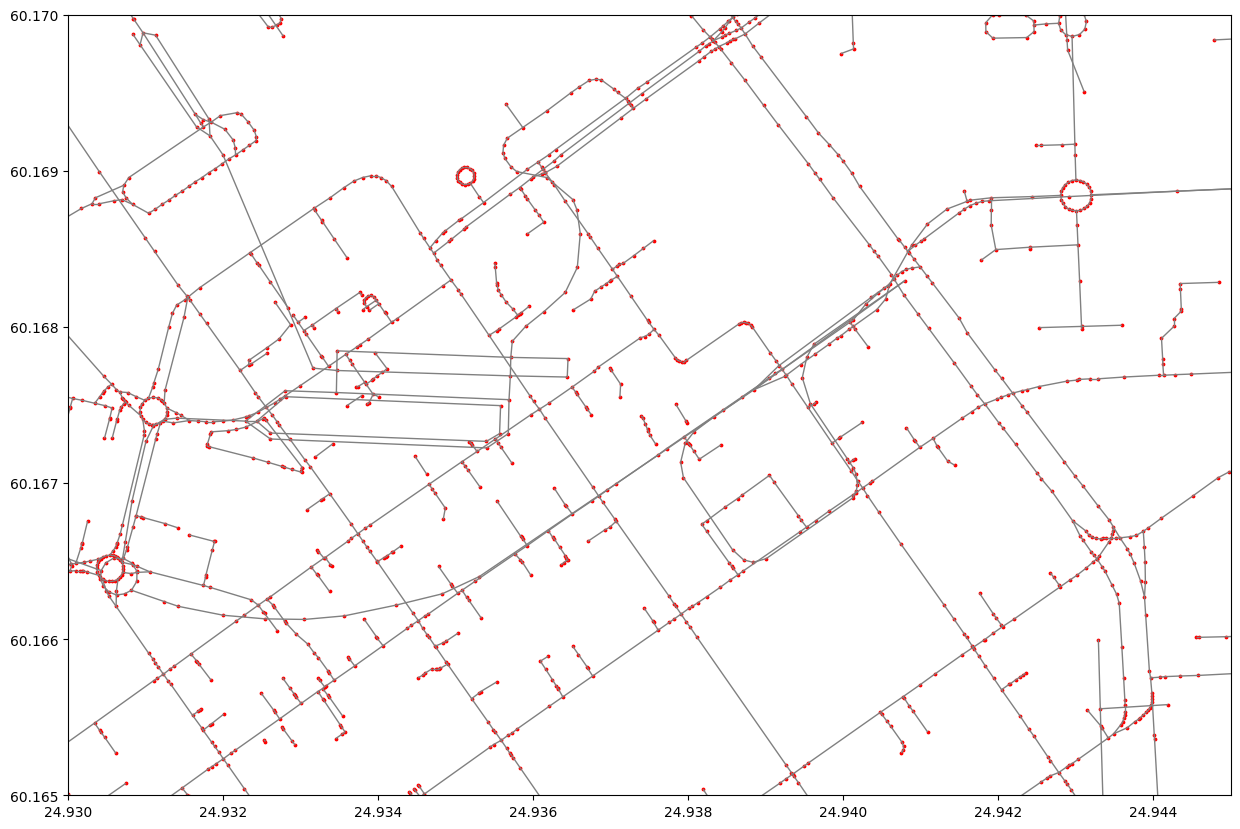

In [171]:
# Parse nodes and edges
nodes, edges = osm.get_network(network_type="driving", nodes=True)

# Plot the data
ax = edges.plot(figsize=(15,15), color="gray", lw=1.0)
ax = nodes.plot(ax=ax, color="red", markersize=3)

# Zoom in to take a closer look
ax.set_xlim([24.93, 24.945])
ax.set_ylim([60.165, 60.17])

Okay, as we can see now we have both the roads (i.e. *edges*) and the nodes that connect the street elements together (in red) that are typically intersections. However, we can see that many of the nodes are in locations that are clearly not intersections. This is intented behavior to ensure that we have full **connectivity** in our network. We can at later stage clean and simplify this network by merging all roads that belong to the same link (i.e. street elements that are between two intersections) which also reduces the size of the network. 

```{note} 

In OSM, the street topology is typically not directly suitable for graph traversal due to missing nodes at intersections which means that the roads are not splitted at those locations. The consequence of this, is that it is not possible to make a turn if there is no intersection present in the data structure. Hence, `pyrosm` will separate all road segments/geometries into individual rows in the data. 
```

Let's take a look what our nodes data look like:

In [172]:
nodes.head()

,version,visible,lat,changeset,timestamp,tags,lon,id,geometry
0,4,False,60.257462,0,0,None,25.126116,286553,POINT (25.12612 60.25746)
1,1,False,60.257626,0,0,None,25.127092,1393097609,POINT (25.12709 60.25763)
2,2,False,60.257771,0,0,None,25.127998,766312702,POINT (25.12800 60.25777)
3,1,False,60.257961,0,0,None,25.129299,1393097450,POINT (25.12930 60.25796)
4,1,False,60.257996,0,0,None,25.129543,4118526050,POINT (25.12954 60.25800)


As we can see, the `nodes` GeoDataFrame contains information about the coordinates of each node as well as a unique `id` for each node. These `id` values are used to determine the connectivity in our network. Hence, `pyrosm` has also added two columns to the `edges` GeoDataFrame that specify **from** and **to** ids for each edge. Column `u` contains information about the **from-id** and column `v` about the **to-id** accordingly:

In [173]:
# Check last four columns
edges.iloc[:5,-4:]

,geometry,u,v,length
0,"LINESTRING (25.12612 60.25746, 25.12709 60.25763)",286553,1393097609,56.875
1,"LINESTRING (25.12709 60.25763, 25.12800 60.25777)",1393097609,766312702,52.513
2,"LINESTRING (25.12800 60.25777, 25.12930 60.25796)",766312702,1393097450,74.826
3,"LINESTRING (25.12930 60.25796, 25.12954 60.25800)",1393097450,4118526050,13.998
4,"LINESTRING (25.12954 60.25800, 25.13060 60.25814)",4118526050,766312444,60.794


We can see that the geometries are now stored as `LineString` instead of `MultiLineString`. At this point, we can fix the issue related to having some pedestrian roads in our network. We can do this by removing all edges from out GeoDataFrame that have `highway` value in `'cycleway', 'footway', 'pedestrian', 'trail', 'crossing'`:

<Axes: >

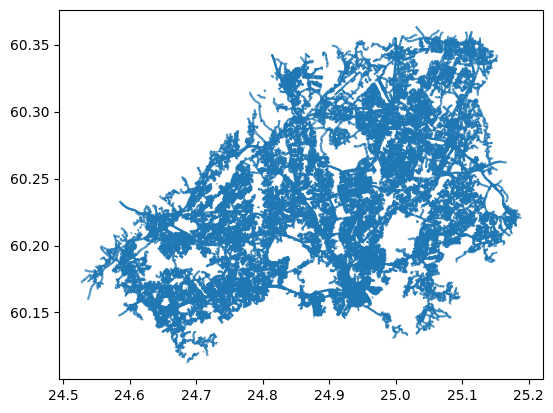

In [174]:
edges = edges.loc[~edges["highway"].isin(['cycleway', 'footway', 'pedestrian', 'trail', 'crossing'])].copy()
edges.plot()

Now we can see, that some of the isolated edges were removed from the data. The character `~` (tilde) in the command above is a *negation* operator that is handy if you want to e.g. remove some rows from your GeoDataFrame based on criteria such as we used here.  

## 2. Modify the data

At this stage, we have the necessary components to build a routable graph (nodes and edges) based on distance. However, in real life the network distance is not the best cost metric to use, because the shortest path (based on distance) is not necessarily always the optimal route in terms of **travel time**. Time is typically the measure that people value more (plus it is easier to comprehend), so at this stage we want to **add a new cost attribute** to our edges GeoDataFrame that converts the metric distance information to travel time (in seconds) based on following formula:

 - `<distance-in-meters> / (<speed-limit-kmph> / 3.6)`
 
Before we can do this calculation, we need to ensure that all rows in `maxspeed` column have information about the speed limit. Let's check the value counts of the column and also include information about the `NaN` values with `dropna` parameter:

In [175]:
# Count values
edges["maxspeed"].value_counts(dropna=False)

maxspeed
None    229362
30       89066
40       52048
50       25098
80        8283
60        5123
20        4365
100       1700
10         830
70         551
120        467
15         199
5           38
walk        16
25           9
Name: count, dtype: int64

As we can see, the rows which do not contain information about the speed limit is the second largest group in our data. Hence, we need to apply a criteria to fill these gaps. We can do this based on following "rule of thumb" criteria in Finland (notice that these vary country by country):

| Road class           | Speed limit within urban region | Speed limit outside urban region |
|----------------------|---------------------------------|----------------------------------|
| motorway             | 100                             | 120                              |
| motorway_link        | 80                              | 80                               |
| trunk                | 60                              | 100                              |
| trunk_link           | 60                              | 60                               |
| primary              | 50                              | 80                               |
| primary_link         | 50                              | 50                               |
| secondary            | 50                              | 50                               |
| secondary_link       | 50                              | 50                               |
| tertiary             | 50                              | 60                               |
| tertiary_link        | 50                              | 50                               |
| unclassified         | 50                              | 80                               |
| unclassified_link    | 50                              | 50                               |
| residential          | 50                              | 80                               |
| living_street        | 20                              | NA                               |
| service              | 30                              | NA                               |
| other                | 50                              | 80                               |

For simplicity, we can consider that all the roads in Helsinki Region follows the *within urban region* speed limits, although this is not exactly true (the higher speed limits start somewhere at the outer parts of the city region). For making the speed limit values more robust / correct, you could use data about urban/rural classification which is available in Finland from [Finnish Environment Institute](https://www.avoindata.fi/data/fi/dataset/kaupunki-maaseutu-luokitus-ykr). Let's first convert our `maxspeed` values to integers using `astype()` method:

In [176]:
edges = edges[edges.maxspeed != 'walk']
edges["maxspeed"] = edges["maxspeed"].astype(float).astype(pd.Int64Dtype())
edges["maxspeed"].unique()

C:\Users\deys1\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<IntegerArray>
[100, 70, 80, 60, 40, 30, <NA>, 50, 120, 20, 10, 15, 5, 25]
Length: 14, dtype: Int64

As we can see, now the maxspeed values are stored in integer format inside an `IntegerArray`, and the `None` values were converted into `pandas.NA` objects that are assigned with `<NA>`. Now we can create a function that returns a numeric value for different road classes based on the criteria in the table above:

In [177]:
def road_class_to_kmph(road_class):
    """
    Returns a speed limit value based on road class, 
    using typical Finnish speed limit values within urban regions.
    """
    if road_class == "motorway":
        return 100
    elif road_class == "motorway_link":
        return 80
    elif road_class in ["trunk", "trunk_link"]:
        return 60
    elif road_class == "service":
        return 30
    elif road_class == "living_street":
        return 20
    else:
        return 50

Now we can apply this function to all rows that **do not have speed limit information**:

In [178]:
# Separate rows with / without speed limit information 
mask = edges["maxspeed"].isnull()
edges_without_maxspeed = edges.loc[mask].copy()
edges_with_maxspeed = edges.loc[~mask].copy()

# Apply the function and update the maxspeed
edges_without_maxspeed["maxspeed"] = edges_without_maxspeed["highway"].apply(road_class_to_kmph)
edges_without_maxspeed.head(5).loc[:, ["maxspeed", "highway"]]

,maxspeed,highway
34,30,service
35,30,service
36,30,service
37,30,service
38,30,service


Okay, as we can see now the `maxspeed` value have been updated according our criteria, and e.g. the `service` road class have been given the speed limit 30 kmph. Now we can recreate the edges GeoDataFrame by combining the two frames: 

In [179]:
edges = pd.concat([edges_with_maxspeed,edges_without_maxspeed])
edges.head(-10).loc[:, ["maxspeed", "highway"]]
edges["maxspeed"].unique()

<IntegerArray>
[100, 70, 80, 60, 40, 30, 50, 120, 20, 10, 15, 5, 25]
Length: 13, dtype: Int64

In [180]:
### Check this cell with Henrikki
##edges = edges_with_maxspeed.append(edges_without_maxspeed)
##edges["maxspeed"].unique()

Great, now all of our edges have information about the speed limit. We can also visualize them:

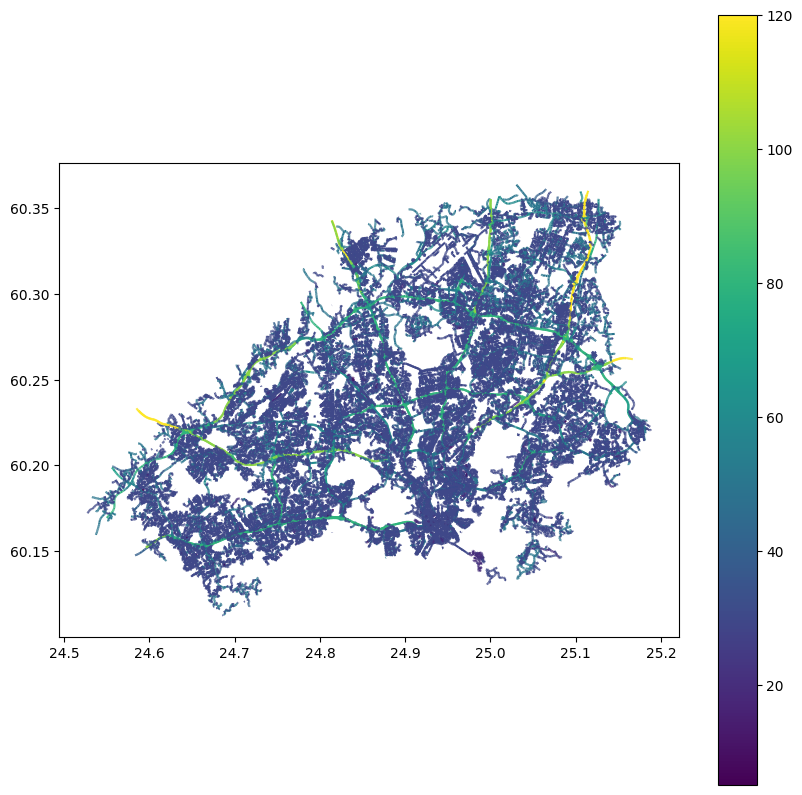

In [181]:
# Convert the value into regular integer Series (the plotting requires having Series instead of IntegerArray) 
edges["maxspeed"] = edges["maxspeed"].astype(int)
ax = edges.plot(column="maxspeed", figsize=(10,10), legend=True)

Finally, we can calculate the travel time in seconds using the formula we saw earlier and add that as a new cost attribute for our network:

In [182]:
edges["travel_time_seconds"] = edges["length"] / (edges["maxspeed"]/3.6)
edges.iloc[0:10, -4:]

,u,v,length,travel_time_seconds
0,286553,1393097609,56.875,2.047500
1,1393097609,766312702,52.513,1.890468
2,766312702,1393097450,74.826,2.693736
3,1393097450,4118526050,13.998,0.503928
4,4118526050,766312444,60.794,2.188584
5,766312444,5515330945,82.557,2.972052
6,5515330945,286537,16.953,0.610308
7,286537,1393097550,78.388,2.821968
8,1393097550,286536,174.982,6.299352
9,251606513,1133480099,54.846,2.820651


Excellent! Now our GeoDataFrame has all the information we need for creating a graph that can be used to conduct shortest path analysis based on length or travel time. Notice that here we assume that the cars can drive with the same speed as what the speed limit is. Considering the urban dynamics and traffic congestion, this assumption might not hold, but for simplicity, we assume so in this tutorial. 

## 3. Build a directed graph for routing using pyrosm

Now as we have calculated the travel time for our edges. We still need to convert our nodes and edges into a directed graph, so that we can start using it for routing. There are easy-to-use functionalities for doing this in `pyrosm` and `osmnx`. 

As a background information, it is good to understand that our edges represents a `directed` network. This means that the information stored in `oneway` column will be used to determine the network structure for the edges based on the rules in that column. If the `oneway` is `'yes'`, it means that the street can be driven only to one direction, and if it is `None` or has a value `"no"`, then that road can be driven to both directions. This means that the tool will make new duplicate edge and reversing the from-id and to-id values in the `u` and `v` columns in the data. In addition, value `-1` in the `oneway` column means that the road can only be driven to one direction but **against** the digitization direction. In such cases, the edge is flipped: the *to-id* (`u`) and *from-id* (`u`) is reversed so that the directionality in the graph is correctly specified. 

- Let's see how we can create a routable NetworkX graph using `pyrosm` with one command:

In [183]:
G = osm.to_graph(nodes, edges, graph_type="networkx")
G

Now we have a routable graph. `pyrosm` actually does some additional steps in the background. By default, `pyrosm` cleans all **unconnected** edges from the graph and only keeps edges that can be reached from every part of the network. In addition, `pyrosm` automatically modifies the graph attribute information in a way that they are compatible with `OSMnx` that provides many handy functionalities to work with graphs. Such as plotting an interactive map based on the graph:

<Axes: >

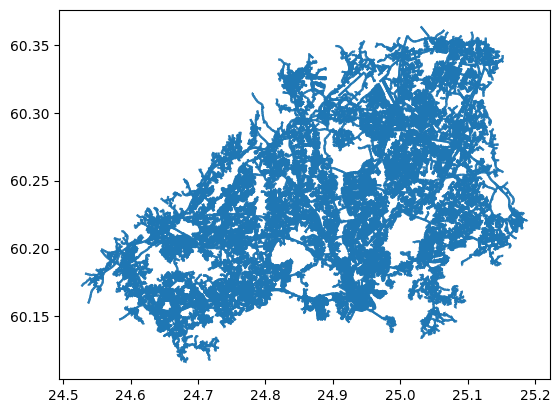

In [184]:
import osmnx as ox 
### Check due to depreciation warning on 25 April
#ox.plot_graph_folium(G)

### Added due to depreciation warning on 25 April
ox.graph_to_gdfs(G, nodes=False).plot()

## 4. Routing with NetworkX

Now we have everything we need to start routing with NetworkX (based on driving distance or travel time). But first, let's again go through some basics about routing.

### Basic logic in routing

Most (if not all) routing algorithms work more or less in a similar manner. The basic steps for finding an optimal route from A to B, is to:
 1. Find the nearest node for origin location \* (+ get info about its node-id and distance between origin and node)
 2. Find the nearest node for destination location \* (+ get info about its node-id and distance between origin and node)
 3. Use a routing algorithm to find the shortest path between A and B
 4. Retrieve edge attributes for the given route(s) and summarize them (can be distance, time, CO2, or whatever)
 
\* in more advanced implementations you might search for the closest edge

This same logic should be applied always when searching for an optimal route between a single origin to a single destination, or when calculating one-to-many -type of routing queries (producing e.g. travel time matrices). 

## Find the optimal route between two locations

Next, we will learn how to find the shortest path between two locations using [Dijkstra's](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm) algorithm.

We use the following coodrinates as our origin and destinations for demonstration purposes. 

In [185]:
# OSM data is in WGS84 so typically we need to use lat/lon coordinates when searching for the closest node

# Origin

orig_y, orig_x = 60.16874416, 24.95721918  # notice the coordinate order (lon, lat)!

# Destination

dest_y, dest_x =  60.1622494, 24.9082137 ##60.16872763, 24.92119326

print("Origin coords:", orig_x, orig_y)
print("Destination coords:", dest_x, dest_y)

Origin coords: 24.95721918 60.16874416
Destination coords: 24.9082137 60.1622494


Okay, we have coordinates now for our origin and destination. Let us find the closest osm nodes for the selected origin and destination locations in the area. 

### Find the nearest nodes

Next, we need to find the closest nodes from the graph for both of our locations. For calculating the closest point we use `ox.distance.nearest_nodes()` -function and specify `return_dist=True` to get the distance in meters.

In [186]:
# 1. Find the closest nodes for origin and destination
orig_node_id, dist_to_orig = ox.distance.nearest_nodes(G, X=orig_x, Y=orig_y, return_dist=True)
dest_node_id, dist_to_dest = ox.distance.nearest_nodes(G, X=dest_x, Y=dest_y, return_dist=True)

print("Origin node-id:", orig_node_id, "and distance:", dist_to_orig, "meters.")
print("Destination node-id:", dest_node_id, "and distance:", dist_to_dest, "meters.")

Origin node-id: 1015191942 and distance: 17.151166613537725 meters.
Destination node-id: 299272103 and distance: 4.266050236105179 meters.


Now we are ready to start the actual routing with NetworkX. 

### Find the fastest route by distance / time

Now we can do the routing and find the shortest path between the origin and target locations
by using the `dijkstra_path()` function of NetworkX. For getting only the cumulative cost of the trip, we can directly use a function `dijkstra_path_length()` that returns the travel time without the actual path. 

With `weight` -parameter we can specify the attribute that we want to use as cost/impedance. We have now three possible weight attributes available: `'length'` and `'travel_time_seconds'`.    

- Let's first calculate the routes between locations by walking and cycling, and also retrieve the travel times

In [187]:
# Calculate the paths by walking and cycling
metric_path = nx.dijkstra_path(G, source=orig_node_id, target=dest_node_id, weight='length')
time_path = nx.dijkstra_path(G, source=orig_node_id, target=dest_node_id, weight='travel_time_seconds')

# Get also the actual travel times (summarize)
travel_length = nx.dijkstra_path_length(G, source=orig_node_id, target=dest_node_id, weight='length')
travel_time = nx.dijkstra_path_length(G, source=orig_node_id, target=dest_node_id, weight='travel_time_seconds')

Okay, that was it! Let's now see what we got as results by visualizing the results.

For visualization purposes, we can use a handy function again from OSMnx called `ox.plot_graph_route()` (for static) or `ox.plot_route_folium()` (for interactive plot).

- Let's first make static maps

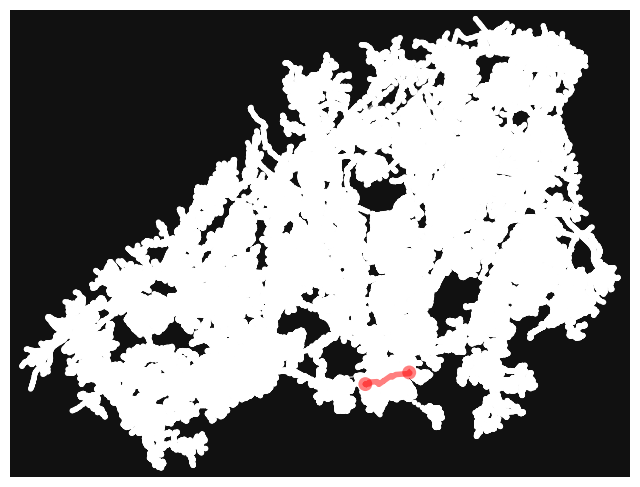

Text(0.5, 133.03826062620507, 'Shortest path distance  3277.5 meters.')

In [188]:
# Shortest path based on distance
fig, ax = ox.plot_graph_route(G, metric_path)

# Add the travel time as title
ax.set_xlabel("Shortest path distance {t: .1f} meters.".format(t=travel_length))

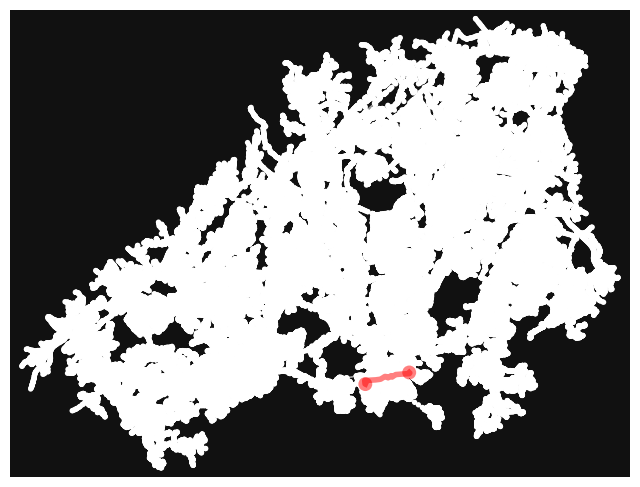

Text(0.5, 133.03826062620507, 'Travel time  5.7 minutes.')

In [189]:
fig, ax = ox.plot_graph_route(G, time_path)

# Add the travel time as title
ax.set_xlabel("Travel time {t: .1f} minutes.".format(t=travel_time/60))

Great! Now we have successfully found the optimal route between our origin and destination and we also have estimates about the travel time that it takes to travel between the locations by walking and cycling. As we can see, the route for both travel modes is exactly the same which is natural, as the only thing that changed here was the constant travel speed.

- Let's still finally see an example how you can plot a nice interactive map out of our results with OSMnx:

In [190]:
ox.plot_route_folium(G, time_path, popup_attribute='travel_time_seconds')

C:\Users\deys1\AppData\Local\Temp\ipykernel_24768\1260170060.py:1: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  ox.plot_route_folium(G, time_path, popup_attribute='travel_time_seconds')


In [191]:
time_path_distance = nx.path_weight(G,time_path,weight='length')

### Load the GHG emission data for Car travel
Here we calculate the carbon emission factors for the single OD pair.
Let us now import the GHG emissions per passenger-kilometer (g CO<sub>2</sub>/pkm) by transport modes Data from the file ["LCA_gCO2_per_pkm_by_transport_mode.csv"](data/LCA_gCO2_per_pkm_by_transport_mode.csv).


In [192]:
#import pandas as pd
ghg_pkm_pv = pd.read_csv("data/LCA_gCO2_per_pkm_by_transport_mode.csv",index_col=0)
ghg_pkm_pv.loc['Total_gCO2'] = ghg_pkm_pv.sum(axis=0)
ghg_pkm_pv.head()
ghg_pkm_pv.columns

Index(['Private e-scooter', 'Shared e-scooter (1st gen.)',
       'Shared e-scooter (new gen.)', 'Private bike', 'Shared bike',
       'Private e-bike', 'Shared e-bike', 'Private moped - ICE',
       'Private moped - BEV', 'Shared moped - ICE', 'Shared moped - BEV',
       'Private car - ICE', 'Private car - HEV', 'Private car - PHEV',
       'Private car - BEV', 'Private car - FCEV', 'Taxi - HEV', 'Taxi - BEV',
       'Taxi - BEV (two packs)', 'Taxi - FCEV', 'Ridesourcing - car - ICE',
       'Ridesourcing - car - HEV', 'Ridesourcing - car - PHEV',
       'Ridesourcing - car - BEV', 'Ridesourcing - car - BEV (two packs)',
       'Ridesourcing - car - FCEV', 'Bus - ICE', 'Bus - HEV', 'Bus - BEV',
       'Bus - BEV (two packs)', 'Bus - FCEV', 'Metro/urban train'],
      dtype='object')

In [193]:
## Create a dictionary of travel mode to co2 emission factors
Car_related_transit_modes = ['Private car - ICE', 'Private car - HEV', 'Private car - PHEV',
       'Private car - BEV', 'Private car - FCEV', 'Taxi - HEV', 'Taxi - BEV',
       'Taxi - BEV (two packs)', 'Taxi - FCEV']##travel_details.transport_mode.unique()
avg_CO2_emission_Car = ghg_pkm_pv.loc['Total_gCO2',Car_related_transit_modes].mean()
avg_CO2_emission_Car

155.44444444444446

In [194]:
avg_CO2_emission_Car * time_path_distance / 1000

512.8556793333333


## Load the locomizer OD data

Now we can take our selected region and can compute shortest paths for all OD pairs in that region. Here we calculate the 

### Loading unique hexagon data
Create a dictionary of nearest osm id for each unique Hexagons


In [195]:
import pandas as pd
##import geopandas as gpd
##hexagon_df= gpd.read_file("data/Helsinki_Hexagons_with_Centroids_SelRings_9Res.csv",index_col=0, ignore_geometry=True)
loco_u_df= pd.read_csv("data/Locomizer_data/Loco_unique_Hexes_LatLon_Res9.csv",index_col=0)

# Create geometry objects from WKT strings
#hexagon_df['geometry'] = gpd.GeoSeries.from_wkt(hexagon_df['geometry'])
# Convert to GDF
#loco_u_gdf = gpd.GeoDataFrame(loco_u_df)
#loco_u_df.head()
all_nearest_osmids = ox.distance.nearest_nodes(G, X=loco_u_df.lon.to_list(), Y=loco_u_df.lat.to_list())

loco_u_df['nearest_osm_node'] = all_nearest_osmids  #loco_u_df.apply(lambda x: ox.distance.nearest_nodes(G, X=x.lon, Y=x.lat),axis=1)
#loco_u_df.to_csv("data/Locomizer_data/Loco_unique_Hexes_LatLon_Res9_nosm.csv")
loco_u_df.head()

,id,lat,lon,geometry,nearest_osm_node
0,89089961267ffff,60.238804,24.643169,"POLYGON ((24.64072390699599 60.23778721015663,...",8081347352
1,89089968003ffff,60.190132,24.725095,POLYGON ((24.722649768070344 60.18911702841219...,5851509356
2,8908996800fffff,60.190463,24.730225,"POLYGON ((24.72777854020724 60.18944780076118,...",2225593683
3,8908996801bffff,60.187418,24.722887,POLYGON ((24.720441789520013 60.18640322540926...,60288706
4,89089968063ffff,60.188410,24.738274,"POLYGON ((24.73582757283475 60.18739503712752,...",3042393704


We want to calculate the shortest paths among the locomizer OD pair centroids. First we have to identify the nearst osm id of these centroids. To do that efficiently and fast, we can create a dictionary to map the nearest osm id to the locomizer centroids, as shown below.

In [196]:
loco_u_dict = loco_u_df.set_index('id').to_dict()
loco_u_df.head()
loco_u_dict['lat']['89089961267ffff']
loco_u_dict['lon']['89089961267ffff']

24.643168607702737

### Loading the sample locomizer OD data
We shall now load the locomizer OD data to calculate the shortest paths, as shown below. Recall that we have sample data for the Helsinki Region in Tutorial T0. 

In [197]:
loco_sample_OD = pd.read_csv(r"data/Locomizer_data/Locomizer_Valid_OD_Hexes_filtered.csv",index_col=0)

There are repeatations of origin-destination pairs in this sample data. We need first to identify all the unique pairs of origin and destination hexagons as below: 

In [198]:
## finding out unique OD pairs
loco_valid_OD = loco_sample_OD[['destination_code_level_9','origin_code_level_9']].drop_duplicates()
len(loco_valid_OD)

7217

Now, we can find the nearest osm nodes of each origin and destination centroid of these unique pairs. 

In [199]:
##hexagon_df_dict
loco_valid_OD['Origin_Centroid_Lat'] = loco_valid_OD.origin_code_level_9.map(lambda x: loco_u_dict['lat'][x])
#loco_u_OD_df.apply(lambda x: loco_u_dict['lat'][str(x.Origin_Hexagon_ID)],axis=1)
loco_valid_OD['Origin_Centroid_Lon'] = loco_valid_OD.origin_code_level_9.map(lambda x: loco_u_dict['lon'][x]) 
loco_valid_OD['Destination_Centroid_Lat'] = loco_valid_OD.destination_code_level_9.map(lambda x: loco_u_dict['lat'][x])
loco_valid_OD['Destination_Centroid_Lon'] = loco_valid_OD.destination_code_level_9.map(lambda x: loco_u_dict['lon'][x])
loco_valid_OD['origin_osm_id'] = loco_valid_OD.origin_code_level_9.map(lambda x: loco_u_dict['nearest_osm_node'][x])
loco_valid_OD['destination_osm_id'] = loco_valid_OD.destination_code_level_9.map(lambda x: loco_u_dict['nearest_osm_node'][x])
loco_valid_OD.reset_index(drop=True).head()


,destination_code_level_9,origin_code_level_9,Origin_Centroid_Lat,Origin_Centroid_Lon,Destination_Centroid_Lat,Destination_Centroid_Lon,origin_osm_id,destination_osm_id
0,890899695b3ffff,89089961267ffff,60.238804,24.643169,60.161603,24.721321,8081347352,5536467272
1,8908996800bffff,89089968003ffff,60.190132,24.725095,60.187749,24.728016,5851509356,2225532534
2,8908996800fffff,89089968003ffff,60.190132,24.725095,60.190463,24.730225,5851509356,2225593683
3,8908996801bffff,89089968003ffff,60.190132,24.725095,60.187418,24.722887,5851509356,60288706
4,89089968063ffff,89089968003ffff,60.190132,24.725095,60.188410,24.738274,5851509356,3042393704


Next, we must find the shortest paths and shortest path lengths between each OD pair by car travel using these nearest osmids. As shown earlier in this tutorial, this can be achieved by the `nx.dijkstra_path_length(G, source, target)` command. To save computational time, we have precalculated these values and inserted them in the data frame within the column names `SP_byTime`, `SP_length_byTime`, and `SP_length_byTime_in_meters`, those representing a list of osmids as the shortest paths by travel time, the length of this shortest path time, and the distance travelled in meters to achieve this shortest path by time, respectively. This data can be found [here](data/Locomizer_data/Locomizer_vOD_Hex_SPs_ByTravelTime.csv). 

In [200]:
#length_dict = nx.multi_source_dijkstra_path_length(G, source=hexagon_OD_df.orig_node_ids.to_list(), target=hexagon_OD_df.dest_node_ids.to_list(), weight='travel_time_seconds')

##loco_valid_OD['SP_length_byTime'] = loco_valid_OD.apply(lambda x: nx.dijkstra_path_length(G, x.origin_osm_id, x.destination_osm_id, weight='travel_time_seconds'),axis=1)
#loco_valid_OD['SP_byTime'] = loco_valid_OD.apply(lambda x: nx.dijkstra_path(G, x.origin_osm_id, x.destination_osm_id, weight='travel_time_seconds'),axis=1)
#loco_valid_OD['SP_length_byTime_in_meters'] =  loco_valid_OD.apply(lambda x: nx.path_weight(G, x.SP_byTime, weight='length'),axis=1)
#hexagon_OD_df == loco_valid_OD
#loco_valid_OD.to_csv("data/Locomizer_data/Locomizer_vOD_Hex_SPs_ByTravelTime.csv",header=True)

In [201]:
loco_valid_OD = pd.read_csv(r"data/Locomizer_data/Locomizer_vOD_Hex_SPs_ByTravelTime.csv",index_col=0)
loco_valid_OD['ghg_co2_emission_Car'] =  loco_valid_OD['SP_length_byTime_in_meters'] *  avg_CO2_emission_Car / 1000
loco_valid_OD.to_csv("data/Locomizer_data/Locomizer_vOD_Hex_SPs_CarTravelTime_and_CO2emissions.csv",header=True)
loco_valid_OD.head()

,destination_code_level_9,origin_code_level_9,Origin_Centroid_Lat,Origin_Centroid_Lon,Destination_Centroid_Lat,Destination_Centroid_Lon,origin_osm_id,destination_osm_id,SP_length_byTime,SP_byTime,SP_length_byTime_in_meters,ghg_co2_emission_Car
0,890899695b3ffff,89089961267ffff,60.238804,24.643169,60.161603,24.721321,8081347352,5536467272,780.096243,"[8081347352, 259236683, 262986992, 259236682, ...",15027.373,2335.921647
1,8908996800bffff,89089968003ffff,60.190132,24.725095,60.187749,24.728016,5851509356,2225532534,50.994360,"[5851509356, 5851509357, 5851509358, 585150935...",424.953,66.056583
2,8908996800fffff,89089968003ffff,60.190132,24.725095,60.190463,24.730225,5851509356,2225593683,27.555000,"[5851509356, 5851509357, 5851509358, 585150935...",229.625,35.693931
3,8908996801bffff,89089968003ffff,60.190132,24.725095,60.187418,24.722887,5851509356,60288706,100.993680,"[5851509356, 5851509357, 5851509358, 585150935...",841.614,130.824221
4,89089968063ffff,89089968003ffff,60.190132,24.725095,60.188410,24.738274,5851509356,3042393704,162.168960,"[5851509356, 5851509357, 5851509358, 585150935...",1351.408,210.068866


## Calculating aggregated GHG emissions due to Car trips 

### According to the locomizer data

Here, we will use the GHG emission factors for a single trip to the localizer data. Let us now recall the following data from our earlier tutorial. 

In [202]:
#loco_df_all = pd.read_csv(r"data/Locomizer_data/SDey_LocomizerOD_MayJune2023_R9.csv",index_col=0)
Car_share_Hsl = 0.35 ## Henkilöauto
PT_share_Hsl = 0.23 ## Joukkoliikenne
Bike_share_Hsl = 0.08  ## Polkupyörä
Walk_share_Hsl = 0.33  ## Kävely
Other_share_Hsl = 0.01 ## Muu

We aim to create a dictionary to map the origin and destination hexagon IDs to the total GHG emissions due to car trips. This dictionary will be used to calculate the GHG emissions in gm/km due to a single car trip. Then it can be converted to aggregated GHG emissions according to the locomizer data of the `EXTRAPOLATED_NUMBER_OF_USERS`.  

In [203]:
car_OD_co2_df = loco_valid_OD[["origin_code_level_9","destination_code_level_9","ghg_co2_emission_Car"]].set_index(["origin_code_level_9","destination_code_level_9"])
car_OD_co2_df.tail()

ghg_co2_emission_Car
origin_code_level_9 destination_code_level_9                      
891126dad87ffff     891126d2d93ffff                    4594.536420
                    891126dad37ffff                     205.320971
                    891126dadbbffff                      69.003654
891126dada3ffff     891126dadabffff                      79.411126
891126dadbbffff     891126dad37ffff                     135.637092

In [204]:
car_OD_co2_dict = car_OD_co2_df.to_dict()
loco_sample_OD["Single_CarTrip_Co2"] = loco_sample_OD.apply(lambda x: car_OD_co2_dict['ghg_co2_emission_Car'][(x.origin_code_level_9, x.destination_code_level_9)],axis=1)
loco_sample_OD["Agg_CarTrip_Co2"] = Car_share_Hsl * loco_sample_OD["Single_CarTrip_Co2"] * loco_df_May["EXTRAPOLATED_NUMBER_OF_USERS"]
loco_sample_OD.head()
## dict[column][key] = value

,destination_code_level_9,origin_code_level_9,NUMBER_OF_USERS,DWELL_TIME,EXTRAPOLATED_NUMBER_OF_USERS,NUMBER_OF_SIGNALS,EXTRAPOLATED_NUMBER_OF_SIGNALS,PROPORTION_OF_USERS,NAMEFIN,Single_CarTrip_Co2,Agg_CarTrip_Co2
0,890899695b3ffff,89089961267ffff,0.666667,5.487959,92.888889,7.444444,935.555556,5.026455,Helsinki,2335.921647,75943.408228
1,8908996800bffff,89089968003ffff,3.666667,3.687860,362.555556,5.222222,509.666667,9.801587,Helsinki,66.056583,8382.213403
2,8908996800fffff,89089968003ffff,0.666667,2.012012,71.000000,0.888889,92.222222,1.014911,Helsinki,35.693931,886.994174
3,8908996801bffff,89089968003ffff,0.666667,2.665467,79.111111,1.222222,154.111111,4.021164,Helsinki,130.824221,3622.377310
4,89089968063ffff,89089968003ffff,2.000000,3.959179,235.666667,2.555556,287.888889,4.082492,Helsinki,210.068866,17327.180281


In [205]:
Agg_co2_loco_Car = loco_sample_OD.groupby(["origin_code_level_9","destination_code_level_9"]).agg('sum').reset_index()
Agg_co2_loco_Car.round(2).head()

,origin_code_level_9,destination_code_level_9,NUMBER_OF_USERS,DWELL_TIME,EXTRAPOLATED_NUMBER_OF_USERS,NUMBER_OF_SIGNALS,EXTRAPOLATED_NUMBER_OF_SIGNALS,PROPORTION_OF_USERS,NAMEFIN,Single_CarTrip_Co2,Agg_CarTrip_Co2
0,89089961267ffff,890899695b3ffff,0.67,5.49,92.89,7.44,935.56,5.03,Helsinki,2335.92,75943.41
1,89089968003ffff,8908996800bffff,3.67,3.69,362.56,5.22,509.67,9.80,Helsinki,66.06,8382.21
2,89089968003ffff,8908996800fffff,0.67,2.01,71.00,0.89,92.22,1.01,Helsinki,35.69,886.99
3,89089968003ffff,8908996801bffff,0.67,2.67,79.11,1.22,154.11,4.02,Helsinki,130.82,3622.38
4,89089968003ffff,89089968063ffff,2.00,3.96,235.67,2.56,287.89,4.08,Helsinki,210.07,17327.18


In [206]:
#OD_loco_May = Total_loco_df_May.pivot(index='ORIGIN_CODE_R9', columns='DESTINATION_CODE_R9', values='Agg_CarTrip_Co2')
#OD_loco_May.fillna("0").head(20)
#OD_loco_May.to_csv("TotalCo2_OD_Matrix_locomizer_May2024.csv",header=True)